# Installing Anomalib

To install anomalib with the required dependencies, please follow the steps under `Install from source` [on GitHub](https://github.com/openvinotoolkit/anomalib?tab=readme-ov-file#-installation).

## Imports


In [1]:
# NOTE: Provide the path to the dataset root directory.
#   If the datasets is not downloaded, it will be downloaded
#   to this directory.
dataset_root = "/Users/rohitpotdukhe/Downloads/Package6941_modified"

In [2]:
#from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display
import torch
from pathlib import Path

from anomalib.data import PredictDataset, Folder
from anomalib.engine import Engine
from anomalib.models import Patchcore
from anomalib import TaskType
from anomalib.loggers import AnomalibTensorBoardLogger
from anomalib.data.utils import read_image
from anomalib.deploy import OpenVINOInferencer
from anomalib.utils.normalization import NormalizationMethod
import os, pprint, yaml, warnings, math, glob, cv2, random, logging
%matplotlib inline
torch.cuda.empty_cache()

### Dataset

Prepare your own dataset for normal and defect pieces.


In [3]:
datamodule = Folder(
    name="ipig_package6941_modified",
    root= dataset_root,
    normal_dir="train/FC",
    abnormal_dir="train/NG",
    # val_path=Path.cwd() / "images" / "val",
    normal_split_ratio=0.2,
    image_size=(256, 256),
    train_batch_size=16,
    eval_batch_size=16,
    task=TaskType.CLASSIFICATION,
    num_workers=8
)
datamodule.setup()
datamodule.prepare_data()

i, data = next(enumerate(datamodule.test_dataloader()))
print(data["image"].shape)

torch.Size([16, 3, 256, 256])


## Model

`anomalib` supports a wide range of unsupervised anomaly detection models. The table in this [link](https://anomalib.readthedocs.io/en/latest/markdown/guides/reference/models/image/index.html) shows the list of models currently supported by `anomalib` library.


### Prepare the Model



In [5]:
#ResNet50, WideResNet50, ResNet101, wide_resnet101_2, ResNeXt101
#wide_resnet50_2. Available layers: ['act1', 'layer1', 'layer2', 'layer3', 'layer4']
#wide_resnet101_2. Available layers: ['act1', 'layer1', 'layer2', 'layer3', 'layer4']
#resnet101. Available layers: ['act1', 'layer1', 'layer2', 'layer3', 'layer4']
model = Patchcore(
    backbone="resnet50", 
    layers=["layer1", "layer2"],
)

## Training

Now that we set up the datamodule and model, we could now train the model.

The final component to train the model is `Engine` object, which handles train/test/predict/export pipeline. Let's create the engine object to train the model.


In [6]:
engine = Engine(
    normalization=NormalizationMethod.MIN_MAX,
    threshold="F1AdaptiveThreshold",
    task=TaskType.CLASSIFICATION,
    image_metrics=["AUROC", "F1Score"],
    accelerator="cpu",
    check_val_every_n_epoch=1,
    devices='auto',
    max_epochs=1,
    num_sanity_val_steps=0,
    val_check_interval=1.0,
)

In [7]:
engine.fit(model=model, datamodule=datamodule)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer


┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name                  ┃ Type                     ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model                 │ PatchcoreModel           │  1.4 M │ train │
│ 1 │ _transform            │ Compose                  │      0 │ train │
│ 2 │ normalization_metrics │ MetricCollection         │      0 │ train │
│ 3 │ image_threshold       │ F1AdaptiveThreshold      │      0 │ train │
│ 4 │ pixel_threshold       │ F1AdaptiveThreshold      │      0 │ train │
│ 5 │ image_metrics         │ AnomalibMetricCollection │      0 │ train │
│ 6 │ pixel_metrics         │ AnomalibMetricCollection │      0 │ train │
└───┴───────────────────────┴──────────────────────────┴────────┴───────┘

Trainable params: 1.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.4 M                                                                                                
Total estimated model params size (MB): 5                                                                          
Modules in train mode: 15                                                                                          
Modules in eval mode: 98

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


Output()

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/loops/optimization/automatic.py:132: `training_step` 
returned `None`. If this was on purpose, ignore this warning...

Output()

`Trainer.fit` stopped: `max_epochs=1` reached.


In [7]:
"""model = Patchcore(
    backbone="wide_resnet101_2", 
    layers=["layer1", "layer2"]
)"""

test_results = engine.test(model=model, datamodule=datamodule)

F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9324217438697815     │
│       image_F1Score       │    0.9509202241897583     │
└───────────────────────────┴───────────────────────────┘

In [7]:
"""model = Patchcore(
    backbone="wide_resnet101_2", 
    layers=["layer1", "layer2", "layer3"],
)"""

test_results = engine.test(model=model, datamodule=datamodule)

F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.
Python(14958) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(14959) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(14960) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(14961) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(14962) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(14963) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Output()

Python(14964) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9182616472244263     │
│       image_F1Score       │    0.9285714030265808     │
└───────────────────────────┴───────────────────────────┘

In [10]:
"""model = Patchcore(
    backbone="resnet101", 
    layers=["layer1", "layer2"],
)"""

test_results = engine.test(model=model, datamodule=datamodule)

F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.
Python(21567) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(21568) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(21570) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(21571) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(21572) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(21573) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Output()

Python(21574) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9408202767372131     │
│       image_F1Score       │    0.9667673707008362     │
└───────────────────────────┴───────────────────────────┘

In [8]:
"""model = Patchcore(
    backbone="resnet50", 
    layers=["layer1", "layer2"],
)"""

test_results = engine.test(model=model, datamodule=datamodule)

F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.
Python(7247) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7248) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7249) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7250) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7251) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7252) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7253) MallocStackLogging: can't turn off malloc stack logging bec

Output()

Python(7254) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │       0.9423828125        │
│       image_F1Score       │    0.9634146094322205     │
└───────────────────────────┴───────────────────────────┘

In [9]:
print(test_results)

[{'image_AUROC': 0.9423828125, 'image_F1Score': 0.9634146094322205}]


In [10]:
from anomalib.deploy import ExportType

export_root = Path.cwd() / 'patchCore_RN50_weights'

export_root.mkdir(parents=True, exist_ok=True)

# Exporting model to OpenVINO
openvino_model_path = engine.export(
    model=model,
    export_type=ExportType.OPENVINO,
    export_root=str(export_root),
)

/opt/homebrew/lib/python3.11/site-packages/anomalib/data/transforms/center_crop.py:57: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if image.numel() == 0:
/opt/homebrew/lib/python3.11/site-packages/anomalib/data/transforms/center_crop.py:61: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if crop_height > image_height or crop_width > image_width:
/opt/homebrew/lib/python3.11/site-packages/anomalib/data/transforms/center_crop.py:41: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use

## OpenVINO Inference

Now that we trained and tested a model, we could check a single inference result using OpenVINO inferencer object. This will demonstrate how a trained model could be used for inference.


## Prediction on all images

In [11]:
def inference(dataset_path, label):
    
    predictions = []

    image_paths = list(dataset_path.glob("**/*.jpg"))

    for image_path in image_paths:
        image = read_image(image_path)

        prediction = inferencer.predict(image=image)
        predictions.append((image_path, prediction, label))
    
    return predictions

In [12]:
def process_all_predictions(normal_predictions, abnormal_predictions):
    all_predictions = []
    all_labels = []
    misclassified_files = []

    # Process normal predictions
    for file_path, image_result, _ in normal_predictions:
        pred_label = 1 if image_result.pred_label else 0
        all_predictions.append(pred_label)
        all_labels.append(0)  # 0 for normal
        if pred_label != 0:
            misclassified_files.append((file_path, 'Normal', 'Predicted as Abnormal'))

    # Process abnormal predictions
    for file_path, image_result, _ in abnormal_predictions:
        pred_label = 1 if image_result.pred_label else 0
        all_predictions.append(pred_label)
        all_labels.append(1)  # 1 for abnormal
        if pred_label != 1:
            misclassified_files.append((file_path, 'Abnormal', 'Predicted as Normal'))
        
    return all_predictions, all_labels, misclassified_files

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(y_true, y_pred):

    classes = ['Normal', 'Abnormal']
    cm = confusion_matrix(y_true, y_pred)

    # Create a figure and a set of subplots
    plt.figure(figsize=(8, 6))
    # Create a heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.show()

## Inference
model = Patchcore(
    backbone="wide_resnet101_2", 
    layers=["layer1", "layer2"]
)

In [16]:
"""openvino_model_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/unite/patchCore_WRN50_package_91_best_weights/weights/openvino/model.bin")
metadata_path = openvino_model_path.parent / "metadata.json" 
print(openvino_model_path.exists(), metadata_path.exists())
print(metadata_path)"""

metadata_path = openvino_model_path.parent / "metadata.json"
print(openvino_model_path.exists(), metadata_path.exists())

inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata_path,  # Path to the metadata file.
    device="CPU",  
)

normal_img_path = Path("/Users/rohitpotdukhe/Downloads/Package6941_modified/val/FC")
abnormal_img_path = Path("/Users/rohitpotdukhe/Downloads/Package6941_modified/val/NG")

normal_predictions = inference(normal_img_path, label = "normal")
abnormal_predictions = inference(abnormal_img_path, label = "abnormal")

all_predictions, all_labels, misclassified_files = process_all_predictions(normal_predictions, abnormal_predictions)

True True


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# Display the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.51875
Precision: 0.5095541401273885
Recall: 1.0
F1 Score: 0.6751054852320676


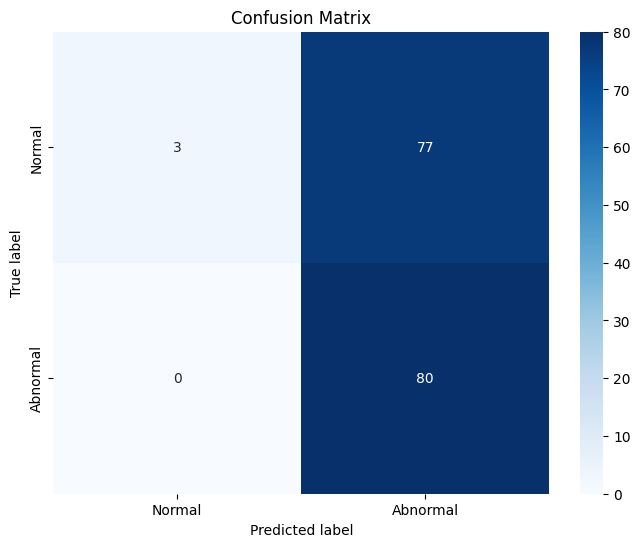

In [19]:
%matplotlib inline

plot_confusion_matrix(all_labels, all_predictions)

## Inferencing

model = Patchcore(
    backbone="wide_resnet101_2", 
    layers=["layer1", "layer2", "layer3"],
)

In [12]:
"""openvino_model_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/unite/patchCore_WRN50_package_91_best_weights/weights/openvino/model.bin")
metadata_path = openvino_model_path.parent / "metadata.json" 
print(openvino_model_path.exists(), metadata_path.exists())
print(metadata_path)"""

metadata_path = openvino_model_path.parent / "metadata.json"
print(openvino_model_path.exists(), metadata_path.exists())

inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata_path,  # Path to the metadata file.
    device="CPU",  
)

normal_img_path = Path("/Users/rohitpotdukhe/Downloads/Package6941_modified/val/FC")
abnormal_img_path = Path("/Users/rohitpotdukhe/Downloads/Package6941_modified/val/NG")

normal_predictions = inference(normal_img_path, label = "normal")
abnormal_predictions = inference(abnormal_img_path, label = "abnormal")

all_predictions, all_labels, misclassified_files = process_all_predictions(normal_predictions, abnormal_predictions)

True True


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# Display the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.5
Precision: 0.5
Recall: 1.0
F1 Score: 0.6666666666666666


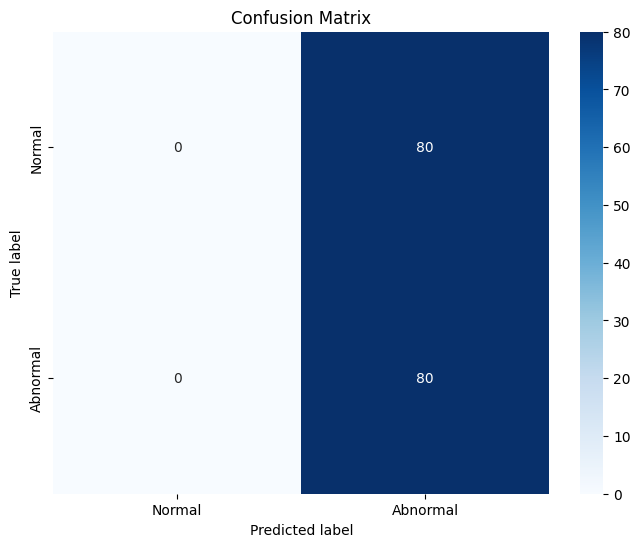

In [14]:
%matplotlib inline

plot_confusion_matrix(all_labels, all_predictions)

## Inferencing

model = Patchcore(
    backbone="resnet101", 
    layers=["layer1", "layer2"],
)

In [15]:
"""openvino_model_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/unite/patchCore_WRN50_package_91_best_weights/weights/openvino/model.bin")
metadata_path = openvino_model_path.parent / "metadata.json" 
print(openvino_model_path.exists(), metadata_path.exists())
print(metadata_path)"""

metadata_path = openvino_model_path.parent / "metadata.json"
print(openvino_model_path.exists(), metadata_path.exists())

inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata_path,  # Path to the metadata file.
    device="CPU",  
)

normal_img_path = Path("/Users/rohitpotdukhe/Downloads/Package6941_modified/val/FC")
abnormal_img_path = Path("/Users/rohitpotdukhe/Downloads/Package6941_modified/val/NG")

normal_predictions = inference(normal_img_path, label = "normal")
abnormal_predictions = inference(abnormal_img_path, label = "abnormal")

all_predictions, all_labels, misclassified_files = process_all_predictions(normal_predictions, abnormal_predictions)

True True


In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# Display the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.51875
Precision: 0.5095541401273885
Recall: 1.0
F1 Score: 0.6751054852320676


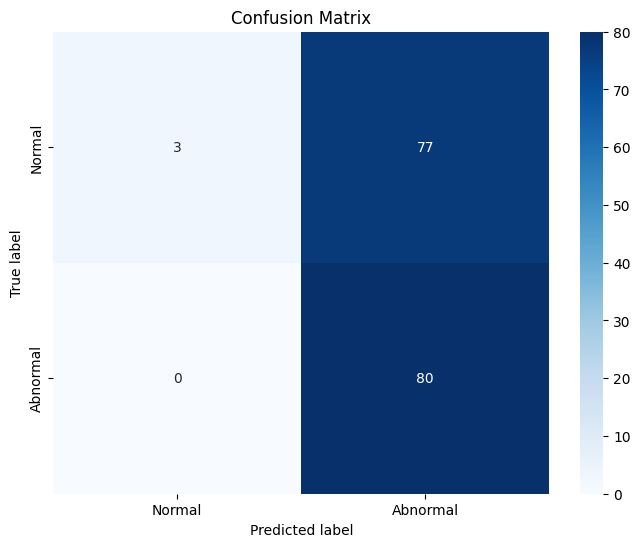

In [17]:
%matplotlib inline

plot_confusion_matrix(all_labels, all_predictions)

## Inferencing

model = Patchcore(
    backbone="resnet50", 
    layers=["layer1", "layer2"],
)

In [14]:
"""openvino_model_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/unite/patchCore_WRN50_package_91_best_weights/weights/openvino/model.bin")
metadata_path = openvino_model_path.parent / "metadata.json" 
print(openvino_model_path.exists(), metadata_path.exists())
print(metadata_path)"""

metadata_path = openvino_model_path.parent / "metadata.json"
print(openvino_model_path.exists(), metadata_path.exists())

inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata_path,  # Path to the metadata file.
    device="CPU",  
)

normal_img_path = Path("/Users/rohitpotdukhe/Downloads/Package6941_modified/val/FC")
abnormal_img_path = Path("/Users/rohitpotdukhe/Downloads/Package6941_modified/val/NG")

normal_predictions = inference(normal_img_path, label = "normal")
abnormal_predictions = inference(abnormal_img_path, label = "abnormal")

all_predictions, all_labels, misclassified_files = process_all_predictions(normal_predictions, abnormal_predictions)

True True


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# Display the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.55
Precision: 0.5263157894736842
Recall: 1.0
F1 Score: 0.6896551724137931


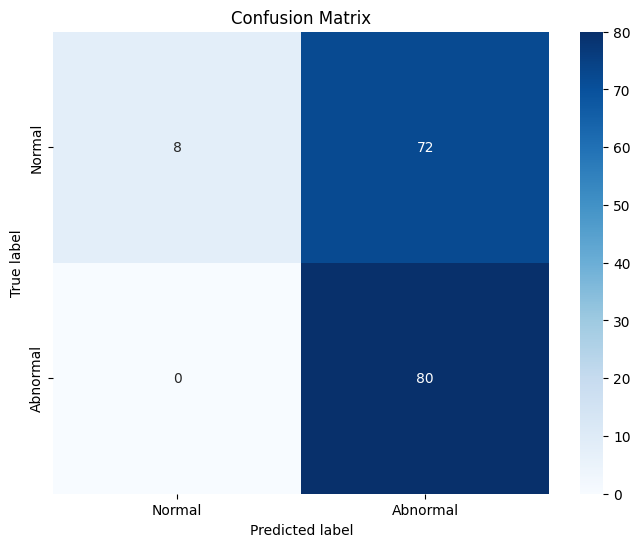

In [16]:
%matplotlib inline

plot_confusion_matrix(all_labels, all_predictions)